# Imports

In [1]:
#!pip install statsmodels matplotlib

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import t, f
import time
import matplotlib.pyplot as plt  # Diesen Import hinzufügen

# 1) Funktionen für Lineare Regression mit QR Decomposition

### 1.1) Lösen eines LGS durch Rückwärts Einsetzen

In [3]:
def backward_substitution(A, y):
    n = A.shape[0]  # Dimension der Dreiecksmatrix bestimmen
    b = np.zeros(n)  # Lösung für den Vektor b

    for i in range(n - 1, -1, -1):
        if A[i, i] == 0:
            raise ValueError("Die Matrix A enthält eine Null auf der Diagonale, keine eindeutige Lösung möglich.")
        
        b[i] = (y[i] - np.dot(A[i, i+1:], b[i+1:])) / A[i, i]

    return b

### 1.2) QR Zerlegung

In [4]:
def gram_schmidt(X):
    n, m = X.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))

    for j in range(m):
        v = X[:, j]
        
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X[:, j])
            v = v - R[i, j] * Q[:, i]

        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

### 1.3) Datensatz simulieren

In [5]:
def create_data(n, p, beta_true):
    np.random.seed(42)
    X = np.random.rand(n, p)
    X = np.column_stack([np.ones(X.shape[0]), X])
    y = X @ beta_true + np.random.randn(n) * 0.1
    return X, y

### 1.4) Funktion zur Durchführung der linearen Regression 

- simuliert einen Datensatz
- führt die lineare Regression durch
- berechnet alle Metriken, die auch statmodels `summary()` ausgibt
- misst die Zeit

In [6]:
def linear_regression_manual_qr(X, y):
    start_time = time.time()
    Q, R = gram_schmidt(X)
    beta = backward_substitution(R, Q.T @ y)

    #sonstige Metriken berechnen
    n, k = X.shape
    k-= 1 # -1, weil die Matrix X eine einser-Spalte für den Offset beinhaltet, der ignoriert werden muss
    df_residuals = n - k - 1 #Freiheitsgrade

    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)

    y_pred = np.dot(X, beta) # mit den durch QR berechneten Betas die vorhergesagten y-Werte des linReg Modells bestimmen
    residuals = y - y_pred

    r_quadrat = 1 - (np.sum((residuals) ** 2) / np.sum((y - np.mean(y)) ** 2))
    adjusted_r_quadrat = 1 - ((n - 1) / df_residuals) * (np.sum((residuals) ** 2) / np.sum((y - np.mean(y)) ** 2))
   
    SSE = np.sum(residuals ** 2)
    SSR = np.sum((y_pred - np.mean(y)) ** 2)
    sigma_hat = np.sqrt(SSE / df_residuals)

    f_statistics = (SSR / k) / (SSE / df_residuals)
    f_p_wert = f.sf(f_statistics, k, df_residuals)
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(sigma_hat ** 2) + SSE / (n * sigma_hat ** 2))

    AIC = 2 * k - 2 * log_likelihood
    BIC = np.log(n) * k - 2 * log_likelihood

    cov_matrix = (sigma_hat ** 2) * XtX_inv

    se = np.sqrt(np.diag(cov_matrix))
    t_werte = beta / se
    p_werte = 2 * (1 - t.cdf(np.abs(t_werte), df_residuals))

    # Konfidenzintervall für die beta-Werte
    alpha = 0.05
    t_crit = stats.t.ppf(1 - alpha / 2, df=df_residuals)  # kritischer t-Wert
    conf_int_lower = beta - t_crit * se
    conf_int_upper = beta + t_crit * se

    # Omnibus-Test
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals, fisher=False)
    omnibus_stat = (n / 6) * (skewness**2 + ((kurtosis - 3)**2) / 4)
    prob_omnibus = 1 - stats.chi2.cdf(omnibus_stat, df=2)

    # Durbin-Watson-Statistik
    dw_statistic = np.sum(np.diff(residuals) ** 2) / np.sum(residuals ** 2)

    # Jarque-Bera-Test
    jarque_bera_stat = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    prob_jb = 1 - stats.chi2.cdf(jarque_bera_stat, df=2)

    # Konditionsnummer
    # U, s, Vt = np.linalg.svd(X)
    # cond_number = np.max(s) / np.min(s)

    end_time = time.time()
    elapsed_time = end_time - start_time

    result = [
        {'Dep. Variable': 'y',
         'Method': 'Linear Regression with QR Decomposition',
         'Observations': n,
         'df': df_residuals,
         'Variables': k},
        {'R-Squared': r_quadrat,
         'Adj. R-Squared': adjusted_r_quadrat,
         'F-statistic': f_statistics,
         'Prob (F-statistic)': f_p_wert,
         'Log-Likelihood': log_likelihood,
         'AIC': AIC,
         'BIC': BIC},
        {'coef': beta,
         'std err': se,
         't': t_werte,
         'P>abs(t)': p_werte,
         'lower boundary': conf_int_lower,
         'upper boundary': conf_int_upper},
        {'Ombibus': omnibus_stat,
         'Prob(Omnibus)': prob_omnibus,
         'Skew': skewness,
         'Kurtosis': kurtosis,
         'Durbin-Watson': dw_statistic,
         'Jarque-Bera (JB)': jarque_bera_stat,
         'Prob(JB)': prob_jb}
         #'Cond. No.': cond_number}
          
    ]

    return result, elapsed_time

### 1.5) Funktion für Durchführung des Benchmarks

In [7]:
def run_benchmark(n_list, beta_true, p, repetitions=5):
    results = []

    for n in n_list:
        times = []
        for _ in range(repetitions):
            X, y = create_data(n, p, beta_true)
            beta, elapsed_time = linear_regression_manual_qr(X, y)
            times.append(elapsed_time)

        avg_time = np.mean(times)
        std_time = np.std(times)
        results.append([n, avg_time, std_time])

    return results

# 2) Durchführung des Benchmarks und Ausgeben der Ergebnisse

### 2.1) Durchführung

In [8]:
n_values = [200000, 500000, 1000000, 5000000, 10000000]
beta_true = [-8, -1.6, 4.1, -10, -9.2, 1.3, 1.6, 2.3]
p = 7
benchmark_results = run_benchmark(n_values, beta_true, p)

### 2.2) Ausgeben der Ergebnisse

In [9]:
for i in benchmark_results:
    print("\n Datenzeilen: ", i[0])
    print("Laufzeit: ", i[1])


 Datenzeilen:  200000
Laufzeit:  0.7270121574401855

 Datenzeilen:  500000
Laufzeit:  0.7489138126373291

 Datenzeilen:  1000000
Laufzeit:  0.8631765365600585

 Datenzeilen:  5000000
Laufzeit:  3.7571731090545653

 Datenzeilen:  10000000
Laufzeit:  5.145037126541138


### 2.3) Plotten der Ergebnisse

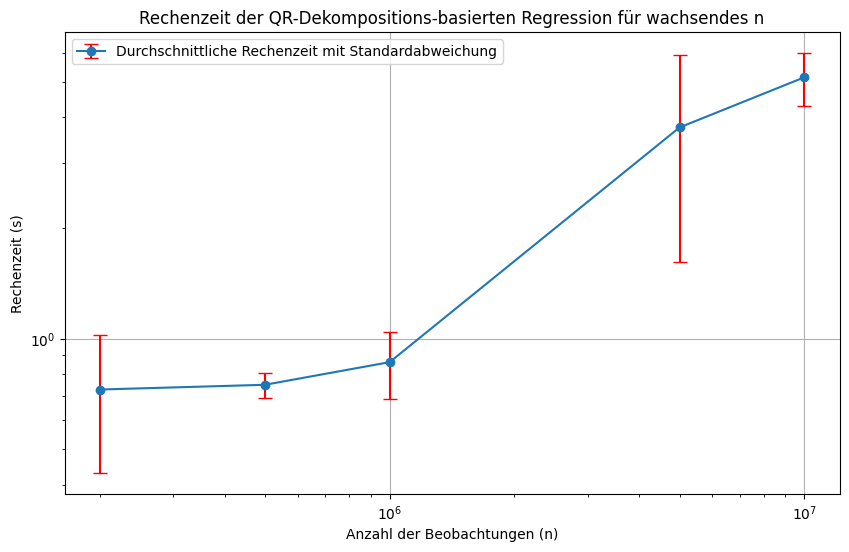

In [10]:
avg_times = [result[1] for result in benchmark_results]
std_times = [result[2] for result in benchmark_results]

plt.figure(figsize=(10, 6))
plt.errorbar(n_values, avg_times, yerr=std_times, fmt='-o', ecolor='r', capsize=5, label='Durchschnittliche Rechenzeit mit Standardabweichung')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Anzahl der Beobachtungen (n)')
plt.ylabel('Rechenzeit (s)')
plt.title('Rechenzeit der QR-Dekompositions-basierten Regression für wachsendes n')
plt.legend()
plt.grid(True)
plt.show()

# 3) Vergleich mit statmodels

### 3.1) statmodels Ausgabe

In [11]:
X, y = create_data(10000, 7, [-8, -1.6, 4.1, -10, -9.2, 1.3, 1.6, 2.3])
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.463e+06
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:51:41   Log-Likelihood:                 8740.0
No. Observations:               10000   AIC:                        -1.746e+04
Df Residuals:                    9992   BIC:                        -1.741e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9986      0.005  -1686.761      0.0

### 3.2) Ausgabe der implementierten Methode

In [12]:
manual, _ = linear_regression_manual_qr(X,y)

print("\nErgebnisse der manuellen Berechnung:\n")

for key, value in manual[0].items():
    print(f"{key}: {value}")

print("-" * 50)  # 50 Zeichen lange Linie

for key, value in manual[1].items():
    print(f"{key}: {value}")

print("-" * 50)  # 50 Zeichen lange Linie

df = pd.DataFrame(manual[2])
print(df)

print("-" * 50)  # 50 Zeichen lange Linie

for key, value in manual[3].items():
    print(f"{key}: {value}")


Ergebnisse der manuellen Berechnung:

Dep. Variable: y
Method: Linear Regression with QR Decomposition
Observations: 10000
df: 9992
Variables: 7
--------------------------------------------------
R-Squared: 0.9994208394069305
Adj. R-Squared: 0.9994204336699257
F-statistic: 2463223.2892255234
Prob (F-statistic): 0.0
Log-Likelihood: 8740.022091638617
AIC: -17466.044183277234
BIC: -17415.571800673402
--------------------------------------------------
        coef   std err            t  P>abs(t)  lower boundary  upper boundary
0  -7.998577  0.004742 -1686.760506       0.0       -8.007873       -7.989282
1  -1.600072  0.003513  -455.423205       0.0       -1.606959       -1.593185
2   4.099500  0.003507  1168.820048       0.0        4.092625        4.106375
3 -10.000056  0.003507 -2851.307248       0.0      -10.006930       -9.993181
4  -9.195339  0.003510 -2619.899498       0.0       -9.202219       -9.188459
5   1.299325  0.003485   372.781716       0.0        1.292492        1.306157
6